In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
import re
import csv
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
from nltk.corpus import stopwords
import PIL

# Youtube Comment Scraper
A simple selenium chromedriver automation which takes a youtube url and scrsapes the comments (replies/time disabled) and saves them to a csv for sentiment processing.

In [2]:
chrome_path = "/Users/darragh/Downloads/chromedriver"
page_url = 'https://www.youtube.com/watch?v=cvFt2Xcuois'


driver = webdriver.Chrome(executable_path=chrome_path)
driver.get(page_url)
#driver.set_window_size(400,500)
time.sleep(5)


title = driver.find_element_by_xpath('//*[@id="container"]/h1/yt-formatted-string').text
print(title)


scroll_wait_time = 2
cycle_count = 30

html = driver.find_element_by_tag_name('html')
html.send_keys(Keys.PAGE_DOWN)  
html.send_keys(Keys.PAGE_DOWN)  
time.sleep(scroll_wait_time * 5)

for i in range(cycle_count):
    html.send_keys(Keys.END)
    time.sleep(scroll_wait_time)

    
    


names = driver.find_elements_by_xpath('//*[@id="author-text"]')
#times = driver.find_element_by_class_name()
comments = driver.find_elements_by_xpath('//*[@id="content-text"]')
#replies = driver.find_elements_by_xpath("//div[@id='loaded-replies']/ytd-comment-renderer//yt-formatted-string[@id='content-text']") 



all_names = [elem.text for elem in names]
#all_times = [elem.text for elem in times]
all_comments = [elem.text for elem in comments]
#all_replies = [elem.text for elem in replies]


write_file = "output.csv"
with open('output.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(all_names, all_comments))


driver.quit()

Breathtaking: K2 - The World's Most Dangerous Mountain | Eddie Bauer


## Username and comment dataframe for processing

In [3]:
df = pd.read_csv('output.csv',
                 header=None, names=['usernames', 'comments'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
df.head()

/Users/darragh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


,usernames,comments
0,NaN,This is the best documentary Ad for a jacket i've ever watched! GG to the climbers and sherpas!
1,NaN,I'm cold just watching this. Scary. 🥶😨
2,NaN,Wish they'd talk about and show the descent. Did they sleep at camp 2 or just powered all the way down?
3,murdo182,"It’s kind of sad that the majority of people don’t realise Nimsdai Purja and team fixed the rope and led the trail blaze to the summit prior to the team in this documentary going for the summit, they literally waited for the work to be done and didn’t give any credit or a mention at all in this film"
4,zak benmalek,My dad swears this is how he got to school every morning


In [4]:
# Cleaning Comments - Regex
df['comments'] = df['comments'].apply(lambda x: 
                                      re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",
                                             '', str(x)))

df.head()

,usernames,comments
0,NaN,This is the best documentary Ad for a jacket ive ever watched GG to the climbers and sherpas
1,NaN,Im cold just watching this Scary
2,NaN,Wish theyd talk about and show the descent Did they sleep at camp 2 or just powered all the way down
3,murdo182,Its kind of sad that the majority of people dont realise Nimsdai Purja and team fixed the rope and led the trail blaze to the summit prior to the team in this documentary going for the summit they literally waited for the work to be done and didnt give any credit or a mention at all in this film
4,zak benmalek,My dad swears this is how he got to school every morning


In [5]:
# Sentiment analysis using polarity and subjectivity within the TextBolb library
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df['polarity'] = df['comments'].apply(pol)
df['subjectivity'] = df['comments'].apply(sub)
# df_clean['comments'] = df_clean['comments'].str.replace(" s ", "'s ")
df.head()

,usernames,comments,polarity,subjectivity
0,NaN,This is the best documentary Ad for a jacket ive ever watched GG to the climbers and sherpas,0.500000,0.150000
1,NaN,Im cold just watching this Scary,-0.550000,1.000000
2,NaN,Wish theyd talk about and show the descent Did they sleep at camp 2 or just powered all the way down,-0.155556,0.288889
3,murdo182,Its kind of sad that the majority of people dont realise Nimsdai Purja and team fixed the rope and led the trail blaze to the summit prior to the team in this documentary going for the summit they literally waited for the work to be done and didnt give any credit or a mention at all in this film,0.040000,0.420000
4,zak benmalek,My dad swears this is how he got to school every morning,0.000000,0.000000


In [6]:
# Creating a sentiment category column based on threshold
def getAnalysis(score):
    if score > 0.1:
        return 1
    #elif score < 0.2 & >-0.5:
        #return 'Neutral'
    else:
        return 0

df['analysis'] = df['polarity'].apply(getAnalysis)
df.head()

,usernames,comments,polarity,subjectivity,analysis
0,NaN,This is the best documentary Ad for a jacket ive ever watched GG to the climbers and sherpas,0.500000,0.150000,1
1,NaN,Im cold just watching this Scary,-0.550000,1.000000,0
2,NaN,Wish theyd talk about and show the descent Did they sleep at camp 2 or just powered all the way down,-0.155556,0.288889,0
3,murdo182,Its kind of sad that the majority of people dont realise Nimsdai Purja and team fixed the rope and led the trail blaze to the summit prior to the team in this documentary going for the summit they literally waited for the work to be done and didnt give any credit or a mention at all in this film,0.040000,0.420000,1
4,zak benmalek,My dad swears this is how he got to school every morning,0.000000,0.000000,0


In [7]:
# Save the progress
df.to_csv('youtube.csv', header=0, index=False)

# Scatter plot of comment polarity and subjectivity

(0, 1.1)

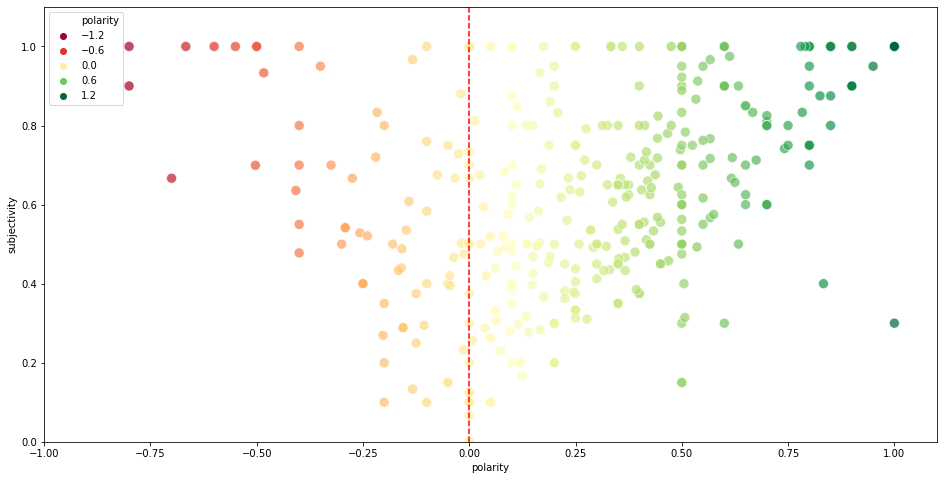

In [8]:
# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(16,8))
sns.scatterplot(x='polarity', y= 'subjectivity', hue='polarity', s=100,
                data=df, alpha=0.7, palette='RdYlGn')
plt.axvline(ymin=0, ymax=1, linestyle='--', color='red')
plt.xlim(-1, 1.1)
plt.ylim(0,1.1)

# Word Counter for WordClouds generate_from_frequency

In [10]:
df['analysis'].value_counts()

1    335
0    215
Name: analysis, dtype: int64

In [11]:
w_count = df['comments'].str.split(expand=True).stack().value_counts()
w_count

the                      376
to                       253
I                        198
and                      180
of                       178
a                        166
you                      121
is                       118
this                     115
for                      112
in                       101
on                       76 
K2                       73 
was                      68 
all                      67 
it                       67 
that                     63 
are                      55 
have                     51 
my                       47 
i                        45 
just                     45 
climb                    44 
with                     42 
summit                   42 
mountain                 42 
so                       41 
but                      40 
The                      39 
they                     38 
from                     37 
people                   36 
me                       35 
at                       35 
like          

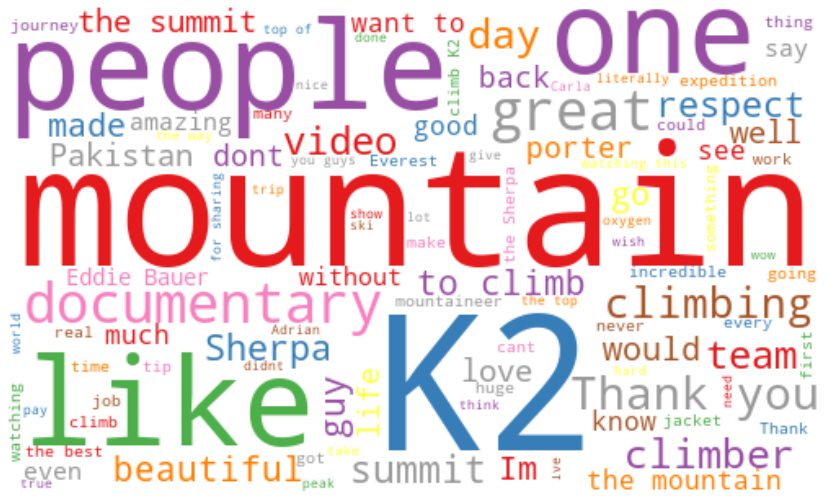

In [13]:
# World Clouds With Stop Words and Max Words
allWords = ''.join([text for text in df['comments']])

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['Also','Really','get','so', 'these', 'yeah', 'for']
stopwords.extend(newStopWords)

wordCloud = WordCloud(width=500, height=300, max_words=100, colormap = 'Set1',
                      stopwords=stopwords, background_color = 'white', random_state=21).generate(allWords)

plt.figure(figsize=(20,9))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show() 
